# DGMC Details

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

project_root = Path("/srv/home/users/anatole93cs/src/graph-nmr")
sys.path.insert(0, str(project_root))

from dgmc.datasets import PairData, generate_y_t
from dgmc.models import DGMC, GIN, GINE, GINEN, GCN

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import matplotlib.pyplot as plt
import networkx as nx


def visualize_graph(data, title, ax):
    """Convert PyG Data to NetworkX graph and visualize it"""
    G = nx.Graph()

    # Add nodes with their features
    num_nodes = data.x.size(0)
    for i in range(num_nodes):
        # Only add label if it exists in y
        if i < data.y.size(0):
            G.add_node(i, feature=data.x[i].item(), label=data.y[i].item())
        else:
            G.add_node(i, feature=data.x[i].item(), label=None)

    # Add edges with weights
    edge_index = data.edge_index.t().numpy()
    edge_attr = getattr(data, 'edge_attr', None)
    edge_weights = {}

    for idx, edge in enumerate(edge_index):
        if edge[0] < edge[1]:  # Avoid duplicate edges in undirected graph
            G.add_edge(edge[0], edge[1])
            if edge_attr is not None:
                weight = edge_attr[idx].item()
                edge_weights[(edge[0], edge[1])] = weight

    # Create layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightblue", node_size=2000, alpha=1.0)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)

    # Add node labels with features and ground truth
    labels = {}
    for node in G.nodes():
        feature = G.nodes[node]["feature"]
        gt_label = G.nodes[node]["label"]
        if gt_label is not None:
            labels[node] = f"{node}\nx:{feature}\ny:{gt_label}"
        else:
            labels[node] = f"{node}\nx:{feature}"

    nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=10)

    # Add edge weight labels if they exist
    if edge_weights:
        edge_labels = {edge: f"{weight:.1f}" for edge, weight in edge_weights.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, ax=ax, font_size=8)

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.axis("off")


def visualize_graph_pair(data_s, data_t, title_s, title_t):
    # Create side-by-side visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Visualize both graphs
    visualize_graph(data_s, title_s, ax1)
    visualize_graph(data_t, title_t, ax2)

    plt.tight_layout()
    plt.show()


def create_pair_data(data_s, data_t):
    data = PairData(
        x_s=data_s.x,
        edge_index_s=data_s.edge_index,
        edge_attr_s=getattr(data_s, 'edge_attr', None),
        label_s=getattr(data_s, 'label', None),
        y_index_s=data_s.y,
        x_t=data_t.x,
        edge_index_t=data_t.edge_index,
        edge_attr_t=getattr(data_s, 'edge_attr', None),
        label_t=getattr(data_s, 'label', None),
        y_t=data_t.y,
        num_nodes=data_s.y.size(0)
    )

    return data

## Graphs

### Graph 1

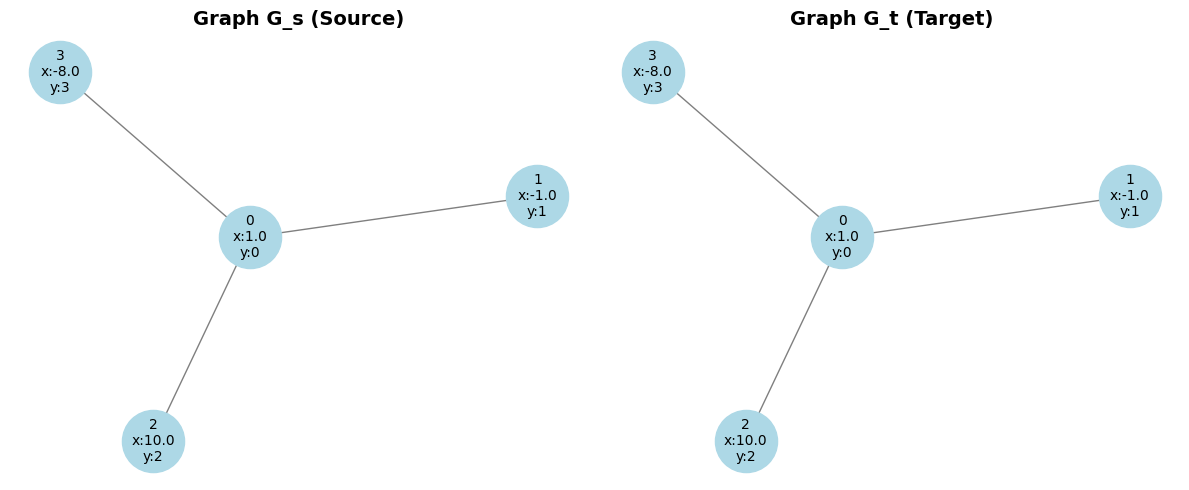

In [3]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_t = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_t = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 2

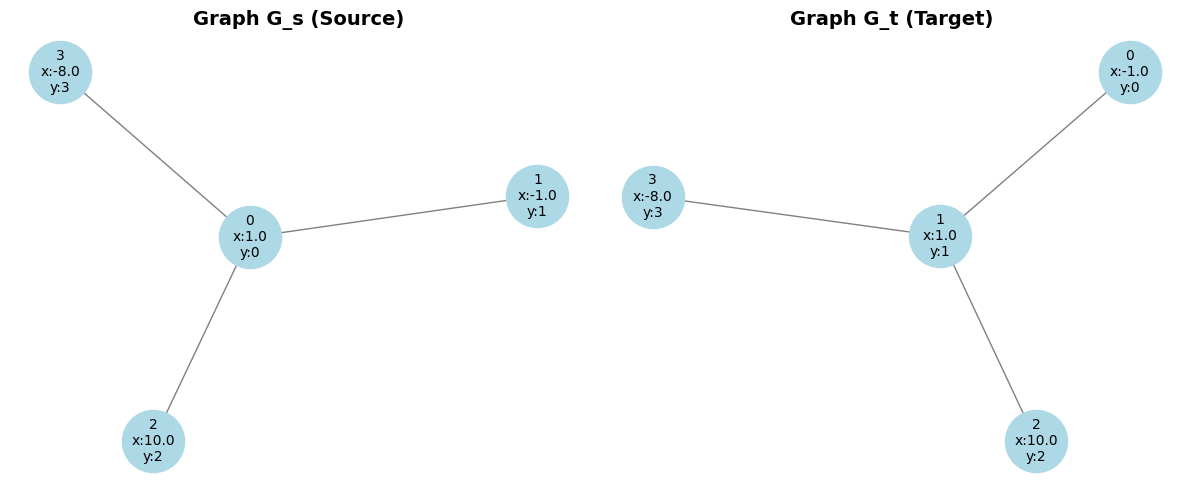

In [4]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([[0], [1], [2], [3]], dtype=torch.long)
y_s_lab = torch.tensor([[3], [0], [1], [2]], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 1, 2, 1, 3], [1, 0, 2, 1, 3, 1]], dtype=torch.long)
x_t = torch.tensor([[-1], [1], [10], [-8]], dtype=torch.float)
y_t = torch.tensor([[0], [1], [2], [3]], dtype=torch.long)
y_t_lab = torch.tensor([[0], [3], [1], [2]], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 3

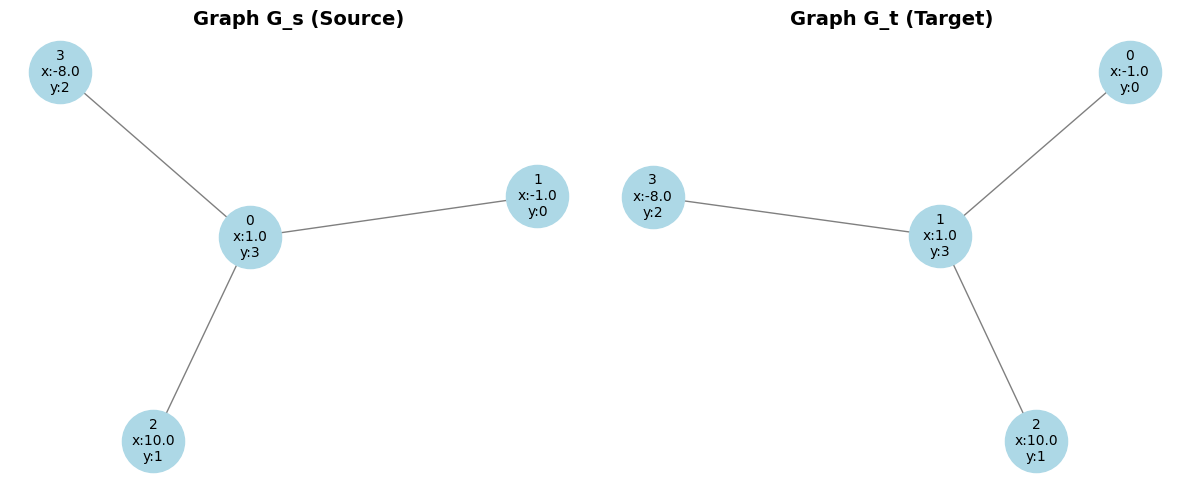

In [5]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([3, 0, 1, 2], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 1, 2, 1, 3], [1, 0, 2, 1, 3, 1]], dtype=torch.long)
x_t = torch.tensor([[-1], [1], [10], [-8]], dtype=torch.float)
y_t = torch.tensor([0, 3, 1, 2], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 4

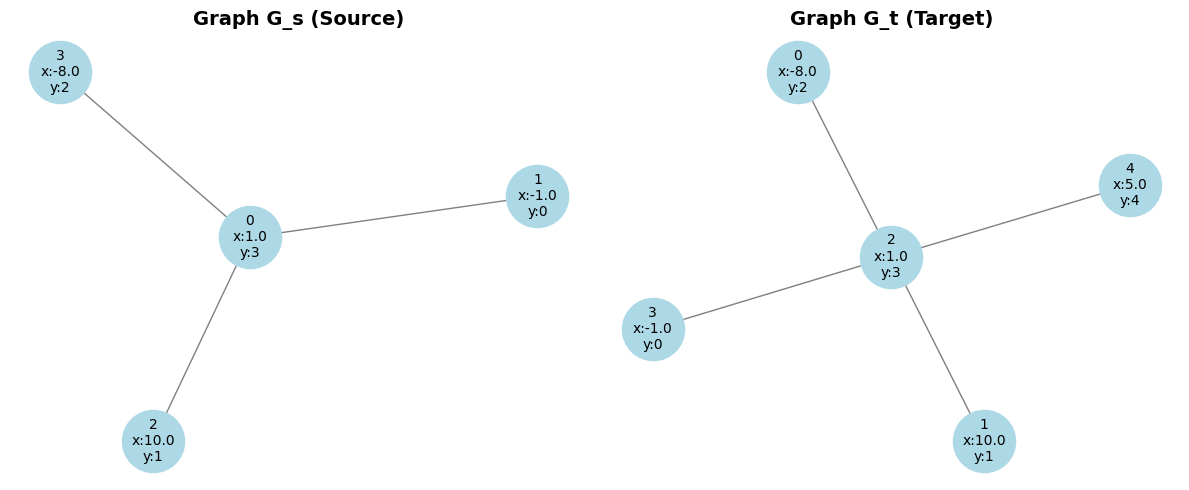

In [6]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([3, 0, 1, 2], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 2, 3, 2, 2, 1, 2], [2, 0, 2, 3, 1, 2, 4]], dtype=torch.long)
x_t = torch.tensor([[-8], [10], [1], [-1], [5]], dtype=torch.float)
y_t = torch.tensor([2, 1, 3, 0, 4], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 5

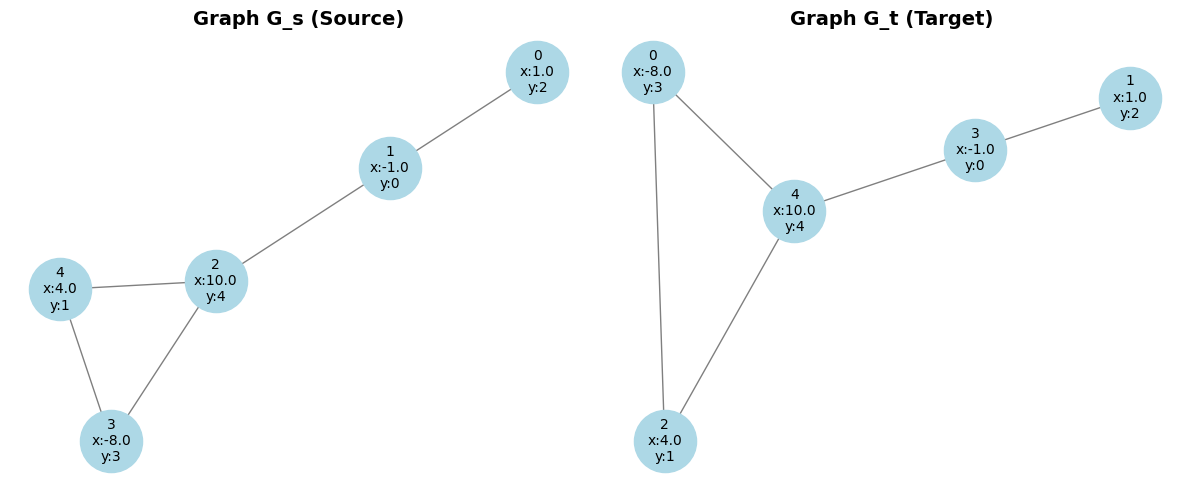

In [7]:
# G_s
edge_index_s = torch.tensor([[0, 1, 1, 2, 2, 3, 2, 4, 3, 4],
                             [1, 0, 2, 1, 3, 2, 4, 2, 4, 3]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8], [4]], dtype=torch.float)
y_s = torch.tensor([2, 0, 4, 3, 1], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 4, 0, 2, 2, 4, 4, 3, 3, 1],
                             [4, 0, 2, 0, 4, 2, 3, 4, 1, 3]], dtype=torch.long)
x_t = torch.tensor([[-8], [1], [4], [-1], [10]], dtype=torch.float)
y_t = torch.tensor([3, 2, 1, 0, 4], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 6

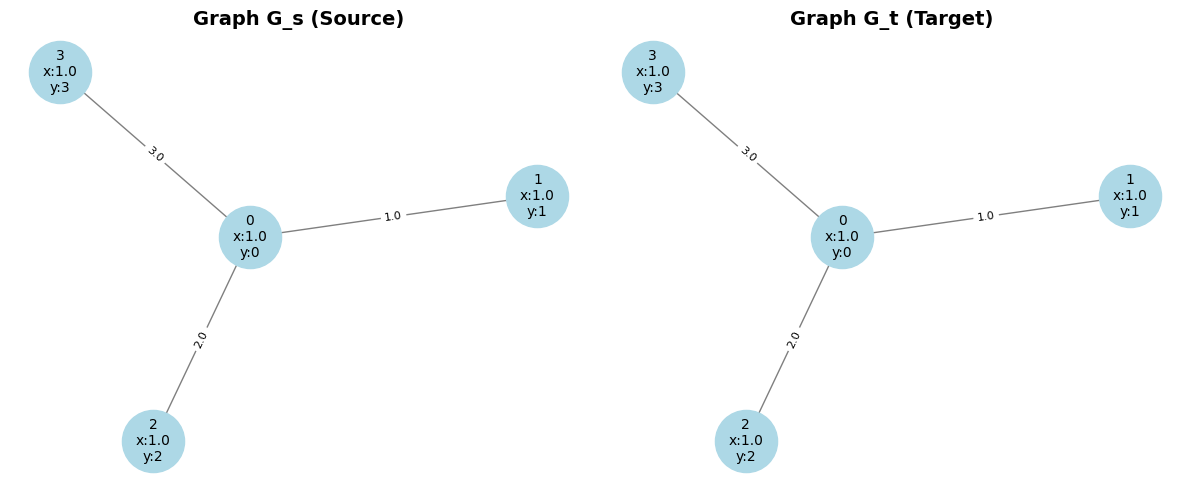

In [8]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_s = torch.tensor([[1], [1], [2], [2], [3], [3]], dtype=torch.float)
label_s = ["A", "B", "C", "D"]
x_s = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
y_s = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, edge_attr=edge_attr_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_t = torch.tensor([[1], [1], [2], [2], [3], [3]], dtype=torch.float)
label_t = ["A", "B", "C", "D"]
x_t = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
y_t = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, edge_attr=edge_attr_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 7

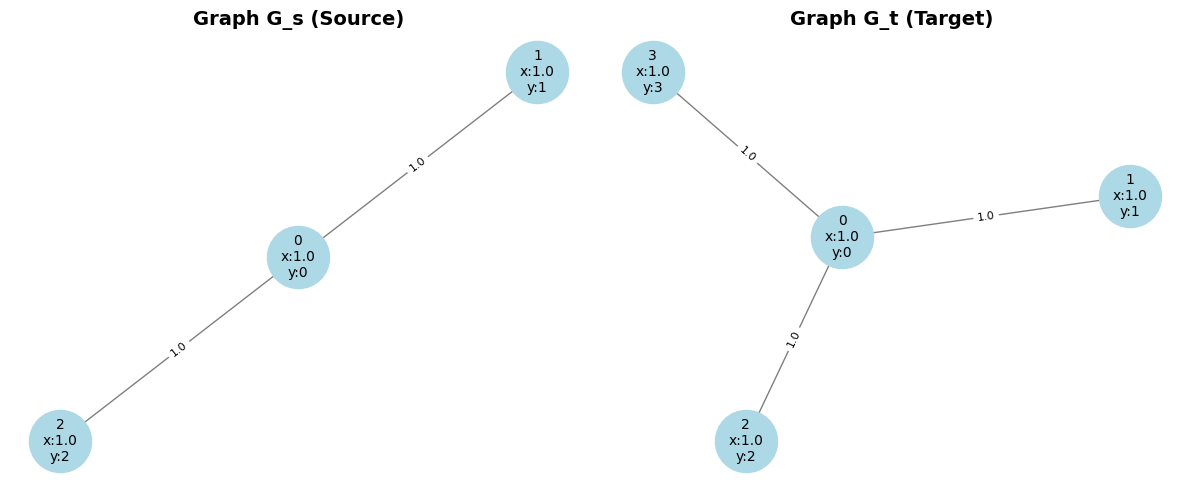

In [58]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2],
                             [1, 0, 2, 0]], dtype=torch.long)
edge_attr_s = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
label_s = ["A", "B", "C", "D"]
x_s = torch.tensor([[1], [1], [1]], dtype=torch.float)
y_s = torch.tensor([0, 1, 2], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, edge_attr=edge_attr_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_t = torch.tensor([[1], [1], [1], [1], [1], [1]], dtype=torch.float)
label_t = ["A", "B", "C", "D"]
x_t = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
y_t = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, edge_attr=edge_attr_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

In [57]:
# torch.manual_seed(11)
psi_1 = GINEN(in_channels=1, out_channels=2, num_layers=1)

h_s = psi_1(data.x_s, data.edge_index_s, edge_attr_s)
h_t = psi_1(data.x_t, data.edge_index_t, edge_attr_t)

print(h_s)
print(h_t)

tensor([[-0.1774,  0.3497],
        [-0.1774,  0.3497],
        [-0.1774,  0.3497]], grad_fn=<AddmmBackward0>)
tensor([[-0.1859,  0.4320],
        [-0.1774,  0.3497],
        [-0.1774,  0.3497],
        [-0.2030,  0.5966]], grad_fn=<AddmmBackward0>)


### Graph 1/1

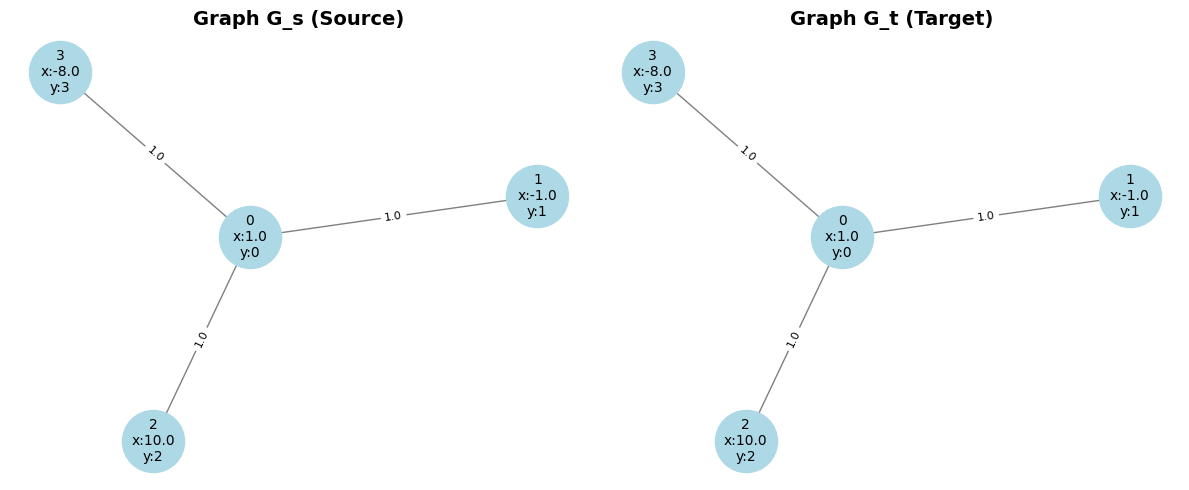

In [9]:

# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_s = torch.tensor([[1], [1], [1], [1], [1], [1]], dtype=torch.float)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_s = ["A", "B", "C", "D"]
y_s = torch.arange(x_s.size(0))
data_s = Data(x=x_s, edge_index=edge_index_s, edge_attr=edge_attr_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_t = torch.tensor([[1], [1], [1], [1], [1], [1]], dtype=torch.float)
x_t = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_t = ["A", "B", "C", "D"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, edge_attr=edge_attr_s, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 2/2

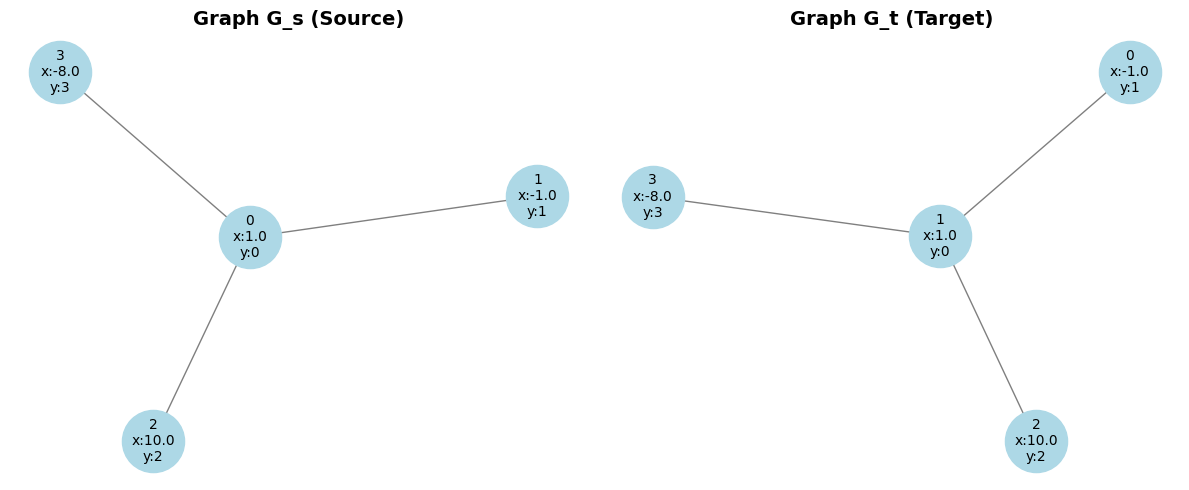

In [10]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_s = ["A", "B", "C", "D"]
y_s = torch.arange(x_s.size(0))
data_s = Data(x=x_s, edge_index=edge_index_s, label_s=label_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 1, 2, 1, 3],
                             [1, 0, 2, 1, 3, 1]], dtype=torch.long)
x_t = torch.tensor([[-1], [1], [10], [-8]], dtype=torch.float)
label_t = ["B", "A", "C", "D"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, label_t=label_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 4/4

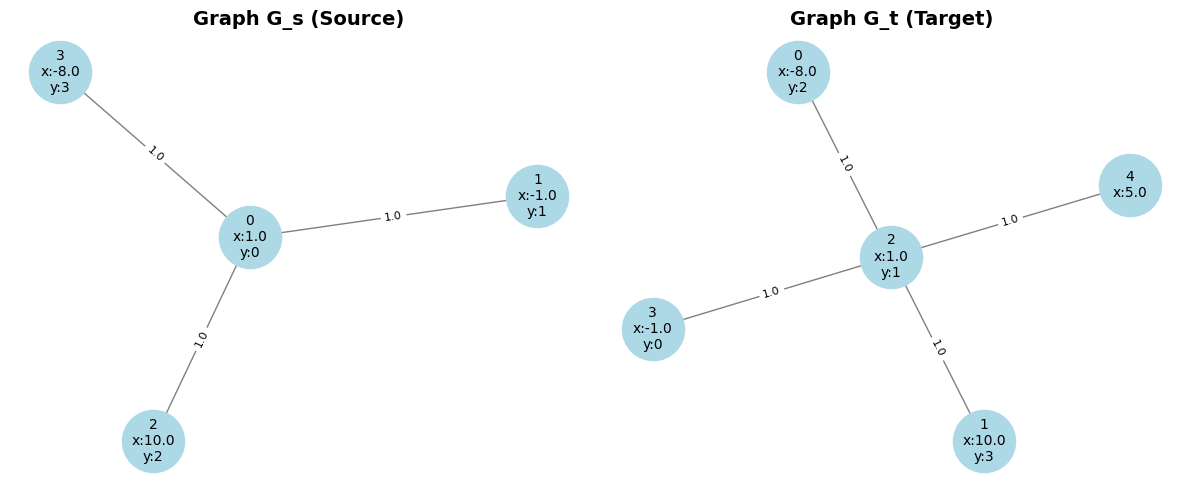

In [11]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_s = torch.ones(edge_index_s.size(1), 1)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_s = ["D", "A", "B", "C"]
y_s = torch.arange(x_s.size(0))
data_s = Data(x=x_s, edge_index=edge_index_s, edge_attr=edge_attr_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 2, 3, 2, 2, 1, 2],
                             [2, 0, 2, 3, 1, 2, 4]], dtype=torch.long)
edge_attr_t = torch.ones(edge_index_t.size(1), 1)
x_t = torch.tensor([[-8], [10], [1], [-1], [5]], dtype=torch.float)
label_t = ["C", "B", "D", "A", "E"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, edge_attr=edge_attr_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 5/5

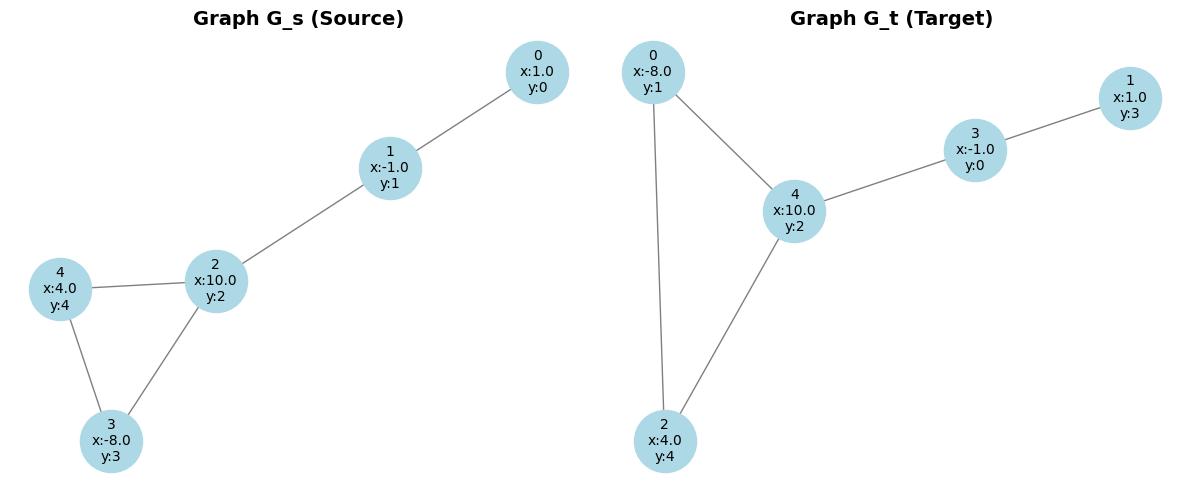

In [8]:
# G_s
edge_index_s = torch.tensor([[0, 1, 1, 2, 2, 3, 2, 4, 3, 4],
                             [1, 0, 2, 1, 3, 2, 4, 2, 4, 3]], dtype=torch.long)
edge_attr_s = torch.ones(edge_index_s.size(1), 1)
x_s = torch.tensor([[1], [-1], [10], [-8], [4]], dtype=torch.float)
y_s = torch.arange(x_s.size(0))
label_s = ["C", "A", "E", "D", "B"]
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 4, 0, 2, 2, 4, 4, 3, 3, 1],
                             [4, 0, 2, 0, 4, 2, 3, 4, 1, 3]], dtype=torch.long)
edge_attr_t = torch.ones(edge_index_t.size(1), 1)
x_t = torch.tensor([[-8], [1], [4], [-1], [10]], dtype=torch.float)
label_t = ["D", "C", "B", "A", "E"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)


data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph Protein

In [51]:
from dgmc.datasets import GraphNmrDataset, pre_transform_to_ones

# Create dataset with pre_transform function to convert x_s and x_t to ones
nmr_dataset = GraphNmrDataset(
    root=project_root / "data/nmr_graphs_2_easy",
    # root=project_root / "data/nmr_graphs_1HS7",
    pre_transform=pre_transform_to_ones,
    force_reload=True
)
data = nmr_dataset[1]

# Overwrite feature vectors with amino acid one-hot encodings
# data.x_s = data.amino_acid_s
# data.x_t = data.amino_acid_t
# data.x_t = data.amino_acid_t.view(-1,1)

data

Processing...
0it [00:00, ?it/s]

2it [00:01,  1.00it/s]
Done!
/srv/home/users/anatole93cs/miniforge3/envs/graph-nmr/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:131: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([dgmc.datasets.graph_nmr.PairData])` to allowlist this global.
  out = fs.torch_load(path)


PairData(x_s=[110, 1], amino_acid_s=[110, 20], edge_index_s=[2, 1486], edge_attr_s=[1486, 1], label_s=[110], y_index_s=[110], x_t=[155, 1], amino_acid_t=[155, 20], edge_index_t=[2, 2840], edge_attr_t=[2840, 1], label_t=[155], y_t=[110], protein='1CKW', num_nodes=110)

## Batching

In [48]:
dataset = [data] * 512
dataloader = DataLoader(dataset, batch_size=4, follow_batch=["x_s", "x_t"])
next(iter(dataloader))

PairDataBatch(x_s=[2232, 1], x_s_batch=[2232], x_s_ptr=[5], amino_acid_s=[2232, 20], edge_index_s=[2, 50576], edge_attr_s=[50576, 1], label_s=[4], y_index_s=[2232], x_t=[2632, 1], x_t_batch=[2632], x_t_ptr=[5], amino_acid_t=[2632, 20], edge_index_t=[2, 69832], edge_attr_t=[69832, 1], label_t=[4], y_t=[2232], protein=[4], num_nodes=2232, batch=[2232], ptr=[5])

## Models

### Embeddings, S_hat and S_0

In [13]:
torch.manual_seed(0)
psi_1 = GIN(in_channels=1, out_channels=2, num_layers=1)
model = DGMC(psi_1, psi_1, num_steps=0, norm_embeddings=True).to(device)

data = data.to(device)
S_0, S_L = model(
    data.x_s,
    data.edge_index_s,
    getattr(data, 'edge_attr_s', None),
    None,
    data.x_t,
    data.edge_index_t,
    getattr(data, 'edge_attr_t', None),
    None
)
S_0
# psi_1(data.x_s, data.edge_index_s, getattr(data, 'edge_attr_s', None))

tensor([[0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0063],
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065],
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065],
        ...,
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0066],
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0067],
        [0.0066, 0.0066, 0.0065,  ..., 0.0065, 0.0065, 0.0069]],
       device='cuda:0', grad_fn=<IndexBackward0>)

### Training

In [52]:
torch.manual_seed(2)
psi_1 = GINEN(in_channels=data.x_s.size(1), out_channels=3, num_layers=2)
psi_2 = GINEN(in_channels=32, out_channels=32, num_layers=2)

model = DGMC(psi_1, psi_2, num_steps=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Run through model
def train():
    total_loss = total_examples = total_correct = total_correct_k = 0
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        data = batch.to(device)
        S_0, S_L = model(
            data.x_s,
            data.edge_index_s,
            getattr(data, "edge_attr_s", None),
            data.x_s_batch,
            data.x_t,
            data.edge_index_t,
            getattr(data, "edge_attr_t", None),
            data.x_t_batch,
        )

        y = torch.stack([data.y_index_s, data.y_t], dim=0)
        loss = model.loss(S_0, y)
        loss = model.loss(S_L, y) + loss if model.num_steps > 0 else loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += model.acc(S_L, y, reduction="sum")
        total_correct_k += model.hits_at_k(3, S_L, y, reduction="sum")
        total_examples += y.size(1)

    return (
        total_loss / len(dataloader),
        total_correct / total_examples,
        total_correct_k / total_examples,
    )


for epoch in range(1, 20):
    loss, acc, acc_k = train()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.2f}, Acc_k: {acc_k:.2f}")

# print(S_L)
# correct = model.acc(S_L, y, reduction="sum")
# print(f"Correct: {correct}")

Epoch: 01, Loss: 12.7919, Acc: 0.00, Acc_k: 0.01
Epoch: 02, Loss: 12.5483, Acc: 0.01, Acc_k: 0.02
Epoch: 03, Loss: 12.4306, Acc: 0.01, Acc_k: 0.03
Epoch: 04, Loss: 12.3596, Acc: 0.01, Acc_k: 0.03
Epoch: 05, Loss: 12.2793, Acc: 0.01, Acc_k: 0.03
Epoch: 06, Loss: 12.1773, Acc: 0.01, Acc_k: 0.03
Epoch: 07, Loss: 12.0738, Acc: 0.01, Acc_k: 0.03
Epoch: 08, Loss: 11.9850, Acc: 0.01, Acc_k: 0.03
Epoch: 09, Loss: 11.8049, Acc: 0.02, Acc_k: 0.04
Epoch: 10, Loss: 11.7017, Acc: 0.02, Acc_k: 0.05
Epoch: 11, Loss: 11.6336, Acc: 0.02, Acc_k: 0.06
Epoch: 12, Loss: 11.5870, Acc: 0.02, Acc_k: 0.07
Epoch: 13, Loss: 11.5553, Acc: 0.03, Acc_k: 0.07
Epoch: 14, Loss: 11.5304, Acc: 0.03, Acc_k: 0.07
Epoch: 15, Loss: 11.4988, Acc: 0.03, Acc_k: 0.07
Epoch: 16, Loss: 11.4904, Acc: 0.03, Acc_k: 0.07
Epoch: 17, Loss: 11.4663, Acc: 0.03, Acc_k: 0.07
Epoch: 18, Loss: 11.4541, Acc: 0.03, Acc_k: 0.08
Epoch: 19, Loss: 11.4356, Acc: 0.03, Acc_k: 0.08


### Torch CUDA clear memory cache

In [12]:
torch.cuda.empty_cache()

### Evaluation

In [ ]:
torch.manual_seed(2)
psi_1 = GINE(in_channels=1, out_channels=5, num_layers=1)
psi_2 = GINE(in_channels=8, out_channels=16, num_layers=1)

model = DGMC(psi_1, psi_2, num_steps=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Run through model
model.eval()
for batch in dataloader:
    data = batch.to(device)
    S_0, S_L = model(
        data.x_s,
        data.edge_index_s,
        data.edge_attr_s,
        data.x_s_batch,
        data.x_t,
        data.edge_index_t,
        data.edge_attr_t,
        data.x_t_batch,
    )

    y = torch.stack([data.y_index_s, data.y_t], dim=0)
    correct = model.acc(S_0, y, reduction="sum")

    print(S_0)
    print(f"Correct: {correct}")